# Data Analysis - Follower Counts

In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.stats
from scipy.stats import stats
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
%matplotlib inline

In [6]:
#Creating artist_codes dataframe
artists = pd.read_csv('Data/spotify_artists_cleaned.csv')

In [7]:
#Limiting artist data to follower counts under 25,000
artists = artists[(artists['artist_followers']<25000)]

In [8]:
print(artists.info())
artists.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45322 entries, 0 to 53243
Data columns (total 25 columns):
artist_id            45322 non-null object
artist_name          45322 non-null object
artist_genres        45322 non-null object
artist_followers     45322 non-null float64
artist_popularity    45322 non-null int64
blues                45322 non-null bool
children             45322 non-null bool
classical            45322 non-null bool
country              45322 non-null bool
edm                  45322 non-null bool
electronic           45322 non-null bool
folk                 45322 non-null bool
funk                 45322 non-null bool
hiphop               45322 non-null bool
indie                45322 non-null bool
jazz                 45322 non-null bool
latin                45322 non-null bool
pop                  45322 non-null bool
r&b                  45322 non-null bool
rap                  45322 non-null bool
reggae               45322 non-null bool
rock                

,artist_id,artist_name,artist_genres,artist_followers,artist_popularity,blues,children,classical,country,edm,...,jazz,latin,pop,r&b,rap,reggae,rock,soul,soundtrack,genre_count
0,4tN3rZ7cChj4Wns2Wt2Nj6,2 AM,"antiviralpop,kpop,minecraft",2075.0,41,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,1
1,3LsQKoRgMc8VEkQn66jfAQ,2:54,metropopolis,10158.0,19,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,1
2,733SPLVnEyXs6GxUEnJ7bx,11/5,"gfunk,hyphy",14489.0,29,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
4,1h2OVSKRdJHnVqyCKqCLkf,?uestlove,phillyrap,16178.0,34,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,1
6,2McJOiKebPtBGqyEYyZQFN,[:SITD:],"aggrotech,darkwave,ebm,electroindustrial,futur...",13580.0,36,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,1


## 1. Examine Follower Data

In [9]:
#Create dataframes filtered by pop, rock, hiphop, and country genres
pop_artists = artists[(artists['pop']==True)]
rock_artists = artists[(artists['rock']==True)]
hiphop_artists = artists[(artists['hiphop']==True)]
country_artists = artists[(artists['country']==True)]
#Print count of rows
print(len(hiphop_artists))
print(len(rock_artists))
print(len(pop_artists))
print(len(country_artists))

3659
5331
10542
659


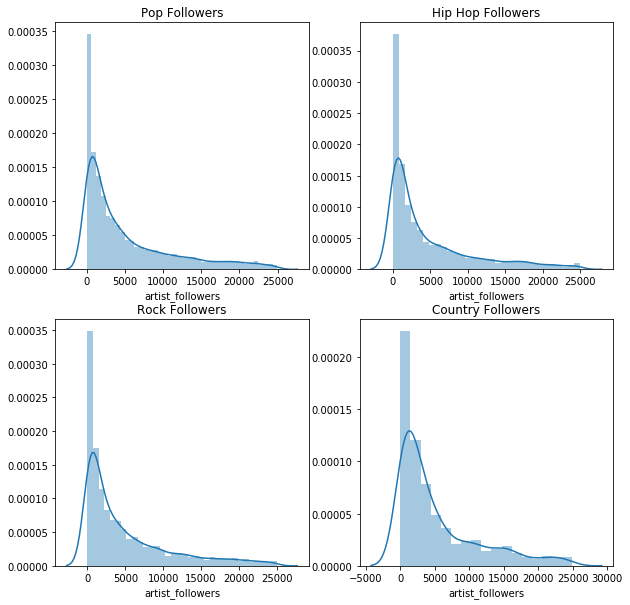

In [189]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(2,2,1)
ax1 = sns.distplot(pop_artists.artist_followers, kde=True)
ax1.set_title('Pop Followers')

ax2 = fig.add_subplot(2,2,2)
ax2 = sns.distplot(hiphop_artists.artist_followers, kde=True)
ax2.set_title('Hip Hop Followers')

ax3 = fig.add_subplot(2,2,3)
ax3 = sns.distplot(rock_artists.artist_followers, kde=True)
ax3.set_title('Rock Followers')

ax4 = fig.add_subplot(2,2,4)
ax4 = sns.distplot(country_artists.artist_followers, kde=True)
ax4.set_title('Country Followers')

plt.show()

In [10]:
#Create test sample array for each genre
hiphop_test_sample = np.array(hiphop_artists['artist_followers'].sample(500))
rock_test_sample = np.array(rock_artists['artist_followers'].sample(500))
pop_test_sample = np.array(pop_artists['artist_followers'].sample(500))
country_test_sample = np.array(country_artists['artist_followers'].sample(500))

In [11]:
#Create dataframe of test sample arrays
followers_test_sample_df = pd.DataFrame({"hiphop": hiphop_test_sample,
                                         'rock': rock_test_sample,
                                         'pop': pop_test_sample,
                                         'country': country_test_sample,
                                        })
followers_test_sample_df.head()

,hiphop,rock,pop,country
0,2392.0,10464.0,273.0,4507.0
1,1866.0,1686.0,1345.0,205.0
2,1250.0,933.0,17709.0,1308.0
3,610.0,4189.0,151.0,1072.0
4,467.0,9221.0,13502.0,462.0


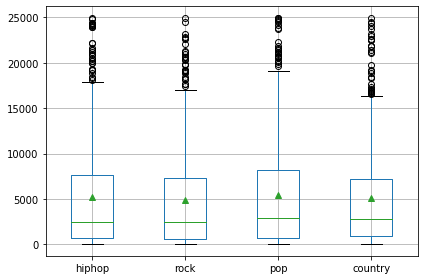

In [12]:
#Boxplot
followers_test_sample_df.boxplot(showmeans=True)
plt.tight_layout()

In [13]:
#Print means
print('Means of the samples are: ', 
      hiphop_test_sample.mean(), 
      rock_test_sample.mean(),
      pop_test_sample.mean(),
      country_test_sample.mean()
     )

Means of the samples are:  5190.72 4861.732 5457.554 5118.41


In [14]:
#Print standard deviation
print('STD of the samples are: ', 
      np.std(hiphop_test_sample), 
      np.std(rock_test_sample),
      np.std(pop_test_sample),
      np.std(country_test_sample)
     )

STD of the samples are:  6184.929343622285 5745.437579521337 6161.129034445229 5783.414949828519


## 2. ANOVA Test

$H_{0}$: $\mu_{pop} = \mu_{rock} = \mu_{hiphop} = \mu_{country}$ 

All mean followers count of Pop, Rock, HipHop, and Country genres are equal.

$H_{a}$: not all means are equal.

$\alpha = 0.05$

In [15]:
#Taking a sample of 20% of the size of each genre dataframe
print(len(hiphop_artists)*.2)
print(len(rock_artists)*.2)
print(len(pop_artists)*.2)
print(len(country_artists)*.2)

731.8000000000001
1066.2
2108.4
131.8


In [126]:
#Create test sample array for each genre
hiphop_sample = np.array(hiphop_artists['artist_followers'].sample(732))
rock_sample = np.array(rock_artists['artist_followers'].sample(1066))
pop_sample = np.array(pop_artists['artist_followers'].sample(2108))
country_sample = np.array(country_artists['artist_followers'].sample(132))

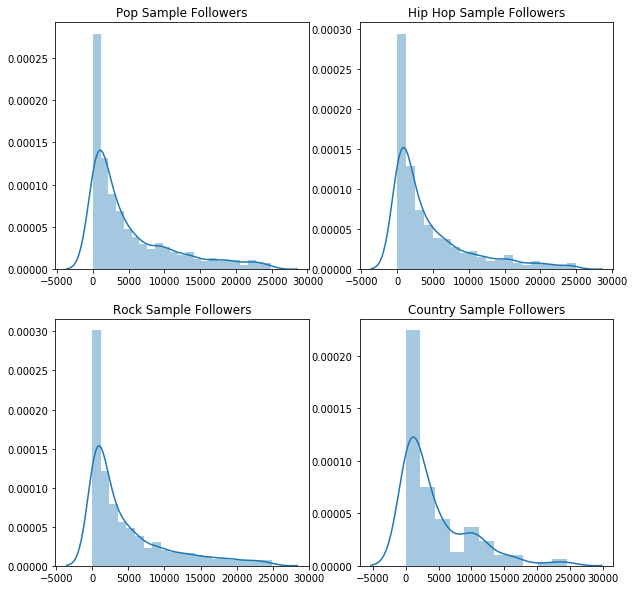

In [191]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(2,2,1)
ax1 = sns.distplot(pop_sample, kde=True)
ax1.set_title('Pop Sample Followers')

ax2 = fig.add_subplot(2,2,2)
ax2 = sns.distplot(hiphop_sample, kde=True)
ax2.set_title('Hip Hop Sample Followers')

ax3 = fig.add_subplot(2,2,3)
ax3 = sns.distplot(rock_sample, kde=True)
ax3.set_title('Rock Sample Followers')

ax4 = fig.add_subplot(2,2,4)
ax4 = sns.distplot(country_sample, kde=True)
ax4.set_title('Country Sample Followers')

plt.show()

In [138]:
#Defining variables

#List of samples
sample_list = [hiphop_sample,
               rock_sample, 
               pop_sample, 
               country_sample]

#Number of groups
k = len(sample_list)

#Sample size of each group
n1 = len(hiphop_sample)
n2 = len(rock_sample)
n3 = len(pop_sample)
n4 = len(country_sample)

#Total sample size
n = n1 + n2 + n3 + n4

#Concatenate all samples to an array
x_all = np.concatenate([hiphop_sample, 
                        rock_sample, 
                        pop_sample, 
                        country_sample])

#Mean for all groups combined
x_bar = x_all.mean()


In [139]:
ss_between = np.sum([len(sample)*(sample.mean() - x_bar)**2 for sample in sample_list])
df_between = k - 1

ss_within = np.sum([((sample - sample.mean())**2).sum() for sample in sample_list])
df_within = n - k

ss_total = np.sum([((sample - x_bar)**2).sum() for sample in sample_list])
df_total = n - 1


In [140]:
ms_between = ss_between / df_between
ms_within = ss_within / df_within

f_score = ms_between / ms_within
print('F-Score:', f_score)

F-Score: 3.28360795341051


In [141]:
p_value = 1 - scipy.stats.f.cdf(f_score, df_between, df_within)
print('P-Value:', p_value)

P-Value: 0.019976003020497957


In [142]:
#Checking results with a stats package
F_statistic, pVal = stats.f_oneway(hiphop_sample,
                                   rock_sample, 
                                   pop_sample, 
                                   country_sample)
print('F-Score:', F_statistic)
print('P-Value:', pVal)

F-Score: 3.2836079534105043
P-Value: 0.019976003020498345


## 3. Tukey's Test

$H_{0}$: $\mu_{1} = \mu_{2}$ 

Mean followers count of each pairwise combination of Pop, Rock, HipHop, and Country genres are equal.

$H_{a}$: $\mu_{1} ≠ \mu_{2}$

$\alpha = 0.05$


This method tests at P<0.05 (correcting for the fact that multiple comparisons are being made which would normally increase the probability of a significant difference being identified). A results of ’reject = True’ means that a significant difference has been observed.

In [72]:
hiphop_df = pd.DataFrame(hiphop_sample)
hiphop_df = hiphop_df.rename(columns={0: 'followers'})
hiphop_df['genre'] = 'hiphop'
hiphop_df['id'] = 0

rock_df = pd.DataFrame(rock_sample)
rock_df = rock_df.rename(columns={0: 'followers'})
rock_df['genre'] = 'rock'
rock_df['id'] = 1

pop_df = pd.DataFrame(pop_sample)
pop_df = pop_df.rename(columns={0: 'followers'})
pop_df['genre'] = 'pop'
pop_df['id'] = 2

country_df = pd.DataFrame(country_sample)
country_df = country_df.rename(columns={0: 'followers'})
country_df['genre'] = 'country'
country_df['id'] = 3

combined_sample_df = pd.concat([hiphop_df, 
                                rock_df, 
                                pop_df, 
                                country_df], axis=0)

In [78]:
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)

In [79]:
MultiComp = MultiComparison(combined_sample_df['followers'],
                            combined_sample_df['genre'])

In [80]:
print(MultiComp.tukeyhsd().summary())

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
 group1 group2  meandiff p-adj    lower      upper   reject
-----------------------------------------------------------
country hiphop -248.4856    0.9 -1722.6643 1225.6931  False
country    pop  454.1341 0.8168  -944.6076 1852.8757  False
country   rock   -45.766    0.9 -1484.2288 1392.6967  False
 hiphop    pop  702.6197 0.0351    33.8076 1371.4317   True
 hiphop   rock  202.7196 0.8944  -545.6162  951.0553  False
    pop   rock -499.9001 0.1252 -1085.8026   86.0024  False
-----------------------------------------------------------


The Tukey test results indicate that a significant difference has been observed between the hiphop and pop genres' follower count means.

## 4. Levene Test

$H_{0}$: $\mu_{1} = \mu_{2}$ 

All mean followers count of each pairwise combination of Pop, Rock, HipHop, and Country genres are equal.

$H_{a}$: $\mu_{1} ≠ \mu_{2}$

$\alpha = 0.05$

Perform Levene test for equal variances.

The Levene test tests the null hypothesis that all input samples are from populations with equal variances. Levene’s test is an alternative to Bartlett’s test bartlett in the case where there are significant deviations from normality.

In [145]:
scipy.stats.levene(hiphop_sample, pop_sample)

LeveneResult(statistic=4.795497837251067, pvalue=0.028615343257720215)

In [144]:
scipy.stats.levene(hiphop_sample, pop_sample, center='mean')

LeveneResult(statistic=9.197530227369434, pvalue=0.002445348701443312)

In [151]:
scipy.stats.levene(rock_sample, pop_sample, center='mean')

LeveneResult(statistic=4.811485181304166, pvalue=0.028342999743326665)

In [152]:
scipy.stats.levene(country_sample, pop_sample, center='mean')

LeveneResult(statistic=4.202855273454721, pvalue=0.04047225774466804)

In [146]:
scipy.stats.levene(hiphop_sample, country_sample, center='mean')

LeveneResult(statistic=0.34677363413931284, pvalue=0.5560994824765572)

In [147]:
scipy.stats.levene(hiphop_sample, rock_sample, center='mean')

LeveneResult(statistic=1.0047546866505364, pvalue=0.3162977698043068)

In [150]:
scipy.stats.levene(country_sample, rock_sample, center='mean')

LeveneResult(statistic=1.2532110176492233, pvalue=0.26316484368638177)

## 5. Bartlett

Perform Bartlett’s test for equal variances

Bartlett’s test tests the null hypothesis that all input samples are from populations with equal variances. For samples from significantly non-normal populations, Levene’s test is more robust.

In [155]:
scipy.stats.bartlett(pop_sample, hiphop_sample)

BartlettResult(statistic=5.8767493484967295, pvalue=0.015342121233637816)

In [118]:
scipy.stats.bartlett(pop_sample, rock_sample)

BartlettResult(statistic=6.766503573231401, pvalue=0.009288463288885478)

In [154]:
scipy.stats.bartlett(pop_sample, country_sample)

BartlettResult(statistic=4.69393405978733, pvalue=0.03026926872564815)

In [156]:
scipy.stats.bartlett(hiphop_sample, rock_sample)

BartlettResult(statistic=0.7051766834626334, pvalue=0.4010497014476849)

In [157]:
scipy.stats.bartlett(country_sample, rock_sample)

BartlettResult(statistic=2.1278654269144033, pvalue=0.14464205804274166)

In [158]:
scipy.stats.bartlett(country_sample, hiphop_sample)

BartlettResult(statistic=1.0367026921472922, pvalue=0.3085895803687274)

## 5. Welch's T-Test

$H_{0}$: $\mu_{pop} <= \mu_{hiphop}$ 

All mean followers count of Pop equals mean follower count of HipHop.

$H_{a}$: $\mu_{pop} > \mu_{hiphop}$

$\alpha = 0.05$

In [166]:
pop_sample.mean()

5266.291271347249

In [163]:
hiphop_sample.mean()

4615.581967213115

In [160]:
scipy.stats.ttest_ind(pop_sample, hiphop_sample, equal_var=False)

Ttest_indResult(statistic=2.6555828928605627, pvalue=0.008009498975059065)

In [159]:
scipy.stats.ttest_ind(pop_sample, rock_sample, equal_var=False)

Ttest_indResult(statistic=2.0740473804222535, pvalue=0.038189568839467475)

In [161]:
scipy.stats.ttest_ind(pop_sample, country_sample, equal_var=False)

Ttest_indResult(statistic=1.7541258310565109, pvalue=0.08140160281359549)

According to the documentation for stats.ttest_ind() the output returned is for a two-tailed t-test. Therefore we must divide the p by 2 for a one-tailed test. 

In [171]:
print(0.008009498975059065/2)
print(0.038189568839467475/2)
print(0.08140160281359549/2)

0.0040047494875295325
0.019094784419733737
0.04070080140679774


In [110]:
scipy.stats.ttest_ind(hiphop_sample, rock_sample, equal_var=False)

Ttest_indResult(statistic=-0.7247323917962211, pvalue=0.4687235888708353)

In [111]:
scipy.stats.ttest_ind(hiphop_sample, country_sample, equal_var=False)

Ttest_indResult(statistic=-0.4600250563277861, pvalue=0.6460425276528607)

In [114]:
scipy.stats.ttest_ind(rock_sample, country_sample, equal_var=False)

Ttest_indResult(statistic=-0.08682723759828766, pvalue=0.9309127466065095)